In [50]:
from causalml.inference.meta import BaseSRegressor, LRSRegressor, MLPTRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
# from causalml.dataset import synthetic_data
import numpy as np
from dataloader import load_IHDP_data
from visualizations import plot_cates_uber, plot_cates

data = load_IHDP_data(training_data='./ihdp_npci_1-100.train.npz',testing_data='./ihdp_npci_1-100.test.npz')

#concatenate t so we can use it as input
xt = np.concatenate([data['x'], data['t']], 1)

X = data['x']
z = data['t'].reshape(-1)
y = data['y'].reshape(-1)


#### S-Learner OLS

In [55]:
import pandas as pd
ols = LinearRegression()

ols.fit(xt, y)

#create fake ones and zeros to feed network
zeros=np.expand_dims(np.zeros(data['x'].shape[0]),1)
ones=np.expand_dims(np.ones(data['x'].shape[0]),1)
x_untreated = np.concatenate([data['x'], zeros], 1)
x_treated = np.concatenate([data['x'], ones], 1)
y0_pred_slearner=ols.predict(x_untreated)
y1_pred_slearner=ols.predict(x_treated)

cate_pred=(y1_pred_slearner - y0_pred_slearner).squeeze()
# print("Average Treatment Effect (True = %2f): %2f" % (np.average(data['mu_1']-data['mu_0']), ate))
# print("Confidence Interval (CI): %2f, %2f " % (lb, ub))

AxesSubplot(0.08,0.125;0.87x0.755)
AxesSubplot(0.08,0.125;0.87x0.755)
AxesSubplot(0.08,0.125;0.87x0.755)

SQRT PEHE: 1.541803035151496
Estimated ATE (True is 3.854): 3.947 



Error CATE Estimates: RED
Individualized CATE Estimates: BLUE
Individualized CATE True: GREEN


(1.541803035151496, 0.052911996841430664)

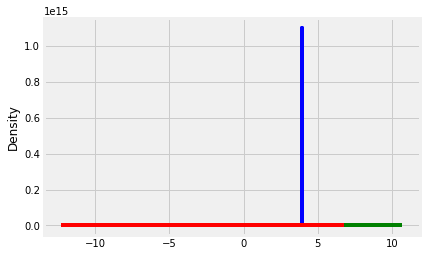

In [56]:
# cate_pred = ols.fit_predict(X, z, y)
plot_cates_uber(cate_pred, data)

#### S-Learner MLP

In [33]:
mlp = BaseSRegressor(learner=MLPRegressor(batch_size=64, max_iter=1000))

ate, lb, ub = mlp.estimate_ate(X, z, y, return_ci=True)
print("Average Treatment Effect (True = %2f): %2f" % (np.average(data['mu_1']-data['mu_0']), ate))
print("Confidence Interval (CI): %2f, %2f " % (lb, ub))

Average Treatment Effect (True = 3.853653): 3.882433
Confidence Interval (CI): 3.768358, 3.996509 


AxesSubplot(0.08,0.125;0.87x0.755)
AxesSubplot(0.08,0.125;0.87x0.755)
AxesSubplot(0.08,0.125;0.87x0.755)

SQRT PEHE: 1.147679243559846
Estimated ATE (True is 3.854): 3.677 



Error CATE Estimates: RED
Individualized CATE Estimates: BLUE
Individualized CATE True: GREEN


(1.147679243559846, 0.3234738889338966)

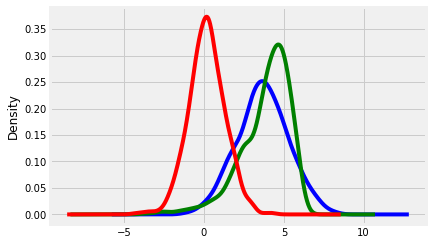

In [35]:
cate_pred = mlp.fit_predict(X, z, y)
plot_cates_uber(cate_pred.reshape(-1), data)

#### T-Learner MLP

In [47]:
t_mlp = MLPTRegressor()

ate, lb, ub = t_mlp.estimate_ate(X, z, y)
print("Average Treatment Effect (True = %2f): %2f" % (np.average(data['mu_1']-data['mu_0']), ate))
print("Confidence Interval (CI): %2f, %2f " % (lb, ub))

Average Treatment Effect (True = 3.853653): 3.382033
Confidence Interval (CI): 3.134037, 3.630029 


AxesSubplot(0.08,0.125;0.87x0.755)
AxesSubplot(0.08,0.125;0.87x0.755)
AxesSubplot(0.08,0.125;0.87x0.755)

SQRT PEHE: 1.1428745369395652
Estimated ATE (True is 3.854): 3.422 



Error CATE Estimates: RED
Individualized CATE Estimates: BLUE
Individualized CATE True: GREEN


(1.1428745369395652, 0.5783251997936203)

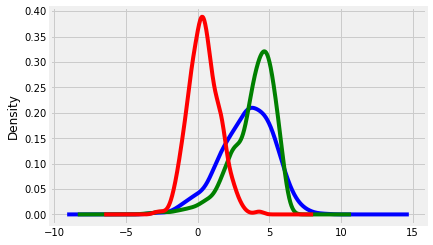

In [49]:
cate_pred = t_mlp.fit_predict(X, z, y)
plot_cates_uber(cate_pred.reshape(-1), data)